In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gdown

In [2]:
# Download the final_campaigns.csv file from Google Drive
file_id_campaigns = '1GtTpo6aDmayZDTzaEbZSPLqvQ8riJN59'  # Google Drive file ID
campaigns_url = f'https://drive.google.com/uc?id={file_id_campaigns}'
output_campaigns = 'final_campaigns.csv'
gdown.download(campaigns_url, output_campaigns, quiet=False)

# Download the Messages.db file from Google Drive
file_id_messages = '1XBSeL6yuW_IOgRnm2FNr0B9FSVxj0Llv'  # Google Drive file ID for messages.db
messages_url = f'https://drive.google.com/uc?id={file_id_messages}'
output_messages = 'Messages.db'
gdown.download(messages_url, output_messages, quiet=False)

campaigns = pd.read_csv(output_campaigns)

conn = sqlite3.connect(output_messages) 
messages = pd.read_sql_query("SELECT * FROM Messages", conn)
conn.close()

Downloading...
From: https://drive.google.com/uc?id=1GtTpo6aDmayZDTzaEbZSPLqvQ8riJN59
To: /Users/yilin/Documents/DSA3101/DSA3101-Project/Customer Behaviour/final_campaigns.csv
100%|██████████| 9.44k/9.44k [00:00<00:00, 8.27MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XBSeL6yuW_IOgRnm2FNr0B9FSVxj0Llv
From (redirected): https://drive.google.com/uc?id=1XBSeL6yuW_IOgRnm2FNr0B9FSVxj0Llv&confirm=t&uuid=f0a9bcf0-c437-4f83-a9a9-f311d23affc0
To: /Users/yilin/Documents/DSA3101/DSA3101-Project/Customer Behaviour/Messages.db
  0%|          | 0.00/3.73G [00:00<?, ?B/s]

Merge campaigns and messages tables 

In [ ]:
merged_data = pd.merge(messages, campaigns, left_on='campaign_id', right_on='id')

Calculate number of messages and conversion rate per Campaign

In [ ]:
# calculate the number of messages per campaign
merged_data['total_count'] = merged_data.groupby('campaign_id')['is_purchased'].transform('count')

# calculate the conversion rate for each message based on their campaign
merged_data['conversion_rate'] = merged_data.groupby('campaign_id')['is_purchased'].transform('sum') / merged_data['total_count']

In [ ]:
campaign_summary = merged_data.groupby('campaign_id').agg(
    total_messages=('is_purchased', 'count'),
    total_purchases=('is_purchased', 'sum')
).reset_index()

campaign_summary['conversion_rate'] = (campaign_summary['total_purchases'] / campaign_summary['total_messages']) * 100

# sort by conversion rate to find the most effective campaigns
most_effective_campaigns = campaign_summary.sort_values(by='conversion_rate', ascending=False)

# sort by total purchases to find the campaigns driving the most sales
most_purchases_campaigns = campaign_summary.sort_values(by='total_purchases', ascending=False)

print("Most effective campaigns based on conversion rate:", most_effective_campaigns)
print("Campaigns with most purchases:", most_purchases_campaigns)



Most effective campaigns based on conversion rate:     campaign_id  total_messages  total_purchases  conversion_rate
72         8015              62                1         1.612903
5           446           41456              226         0.545156
15         1487             456                2         0.438596
47         4300             814                3         0.368550
19         2012             356                1         0.280899
..          ...             ...              ...              ...
65         7078             823                0         0.000000
66         7119              23                0         0.000000
67         7131            1537                0         0.000000
68         7181            1116                0         0.000000
27         2448            1115                0         0.000000

[89 rows x 4 columns]
Campaigns with most purchases:     campaign_id  total_messages  total_purchases  conversion_rate
88        18223         1334514      

Campaigns leveraging precision-targeted approaches, such as campaign ID 8015, achieved the highest conversion rate despite delivering fewer messages. This suggests that by precisely targeting a smaller, more relevant audience, the campaign effectively engaged recipients and maximized conversion potential. This strategy highlights the efficacy of targeted marketing, delivering impactful results by focusing on quality interactions over quantity.

Campaign 18223's high volume showcases successful broad reach strategies despite lower conversion rates. This approach underscores how achieving scale can be crucial for increasing total sales figures, demonstrating that a wide-reaching strategy can effectively complement targeted efforts to achieve comprehensive market impact.

In [ ]:
merged_data['sent_at'] = pd.to_datetime(merged_data['sent_at'], errors='coerce')

merged_data['year'] = merged_data['sent_at'].dt.year
merged_data['month'] = merged_data['sent_at'].dt.month
merged_data['day_of_week'] = merged_data['sent_at'].dt.dayofweek
merged_data['hour'] = merged_data['sent_at'].dt.hour
merged_data['is_weekend'] = merged_data['sent_at'].dt.dayofweek >= 5

features = [
    'subject_length', 'subject_with_personalization', 'subject_with_deadline', 'subject_with_emoji',
    'subject_with_bonuses', 'subject_with_discount', 'subject_with_saleout',
    'month', 'day_of_week', 'hour', 'is_weekend'
]


# prepare the data for modeling
X = merged_data[features]
y = merged_data['is_purchased']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# initialise and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# predict and evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9996970104763769


The model achieved an accuracy of 99.97%, indicating high prediction success. This high accuracy suggests potential class imbalance, as the model might predominantly predict the majority class. Further evaluation with precision and recall metrics may be required to ensure balanced performance.

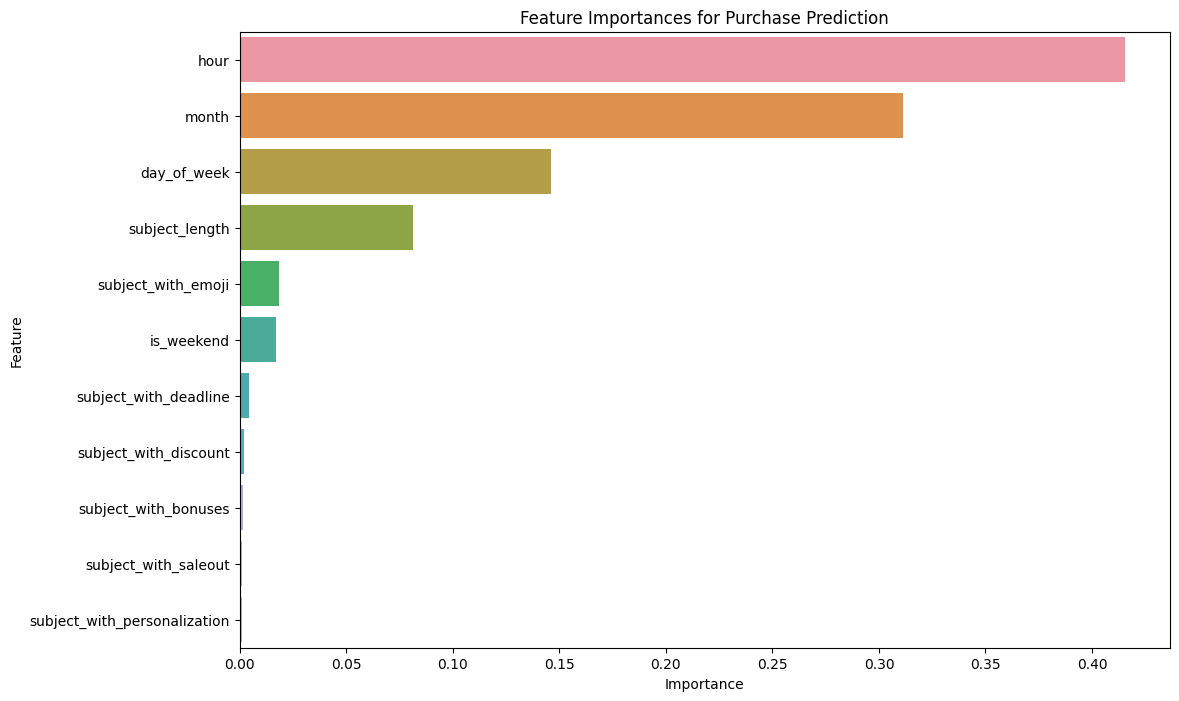

Feature Importances:                               Importance
hour                            0.415638
month                           0.311105
day_of_week                     0.146221
subject_length                  0.081472
subject_with_emoji              0.018309
is_weekend                      0.017162
subject_with_deadline           0.004277
subject_with_discount           0.002209
subject_with_bonuses            0.001767
subject_with_saleout            0.000967
subject_with_personalization    0.000873


In [ ]:
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame(importances, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

# plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances for Purchase Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("Feature Importances:", feature_importances)


The "hour" of extracted from `sent_at` column emerges as the most critical feature, followed by "month" and "day_of_week". This indicates that specific sending times substantially enhances purchase probability. 

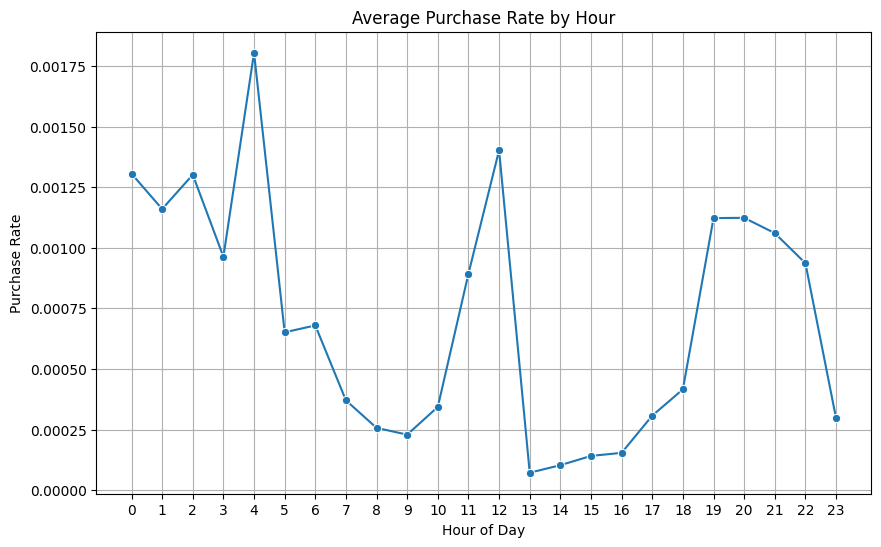

In [ ]:
hourly_performance = merged_data.groupby('hour')['is_purchased'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='is_purchased', data=hourly_performance, marker='o')
plt.title('Average Purchase Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Purchase Rate')
plt.xticks(range(24))
plt.grid(True)
plt.show()


We identified peak engagement hours at 4AM and 12PM, which suggest the optimal times for message delivery. These hours likely correspond with early risers and lunchtime breaks, when individuals are more available to engage with their devices. 

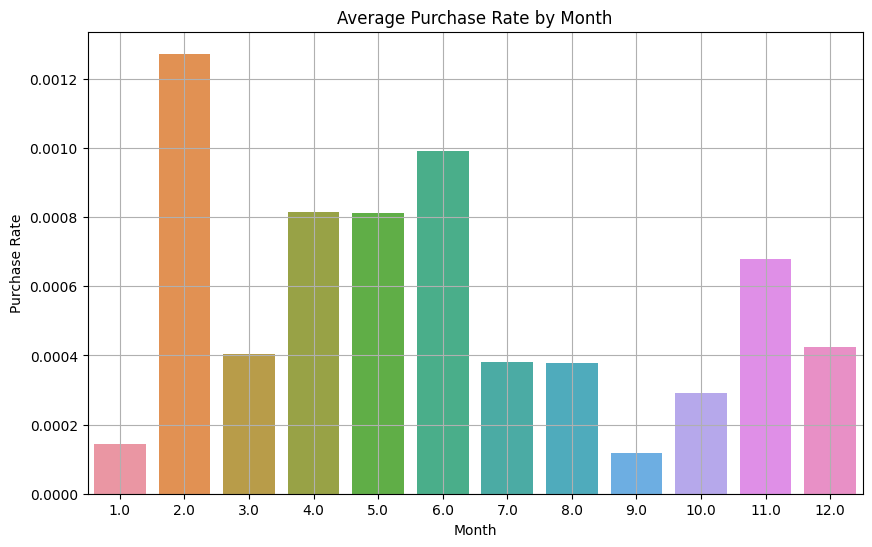

In [ ]:
monthly_performance = merged_data.groupby('month')['is_purchased'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='is_purchased', data=monthly_performance)
plt.title('Average Purchase Rate by Month')
plt.xlabel('Month')
plt.ylabel('Purchase Rate')
plt.grid(True)
plt.show()


We identified peak engagement to be in February and June. The February peak may align with New Year purchases and celebrations such as Valentine's Day. The June peak may be attributed to Mid-Year Sales and an increase in activities related to summer vacations.

Conclusion:

Our analysis of conversion rates and purchase volumes demonstrates the effectiveness of combining precision-targeted and large-scale tactics. By optimizing timing and content strategy, we can achieve higher conversions and sales volume. This dual approach leverages detailed temporal insights and feature evaluations to enhance marketing effectiveness, optimize resource allocation, and improve campaign design.